In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage as ndi
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

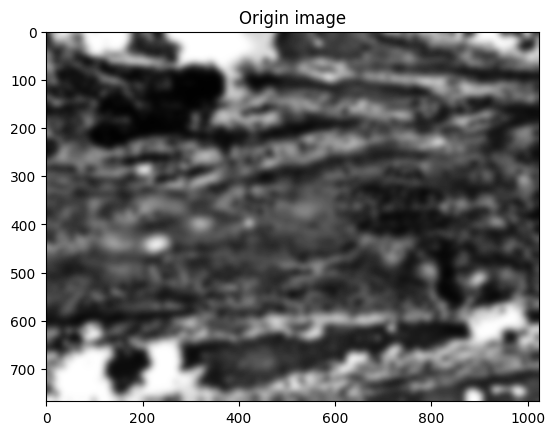

In [2]:
# Show origin picture 
# image = cv2.imread('data/B5/0.jpg')
image_0 = cv2.imread('/mnt/DataK/Project/ThyroidCancer/data/origin_data/B256/B2/z4907540008741_29ecba73d3d0cc14addd7cba092493d3.jpg')

# Áp dụng lọc Bilateral
# image = cv2.bilateralFilter(image, 255, 25, 25) # -> quá lâu 

# Áp dụng lọc Median
# image = cv2.medianBlur(image, 15) # -> chất lượng giảm đáng kể 

# Áp dụng lọc Gaussian
image = cv2.GaussianBlur(image_0, (45, 45), 0)

# Chuyển đổi ảnh sang màu xám
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 3D picture to 2D picture

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
# ax.imshow(image)
ax.set_title('Origin image')
plt.show()

In [3]:
print(image.shape)
# Sử dụng np.unique để xác định các giá trị duy nhất
unique_values, counts = np.unique(image, return_counts=True)

# In ra các giá trị duy nhất và số lần xuất hiện của chúng
print("Các giá trị duy nhất:", unique_values)
print("Số lần xuất hiện tương ứng:", counts)

(768, 1024)
Các giá trị duy nhất: [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 

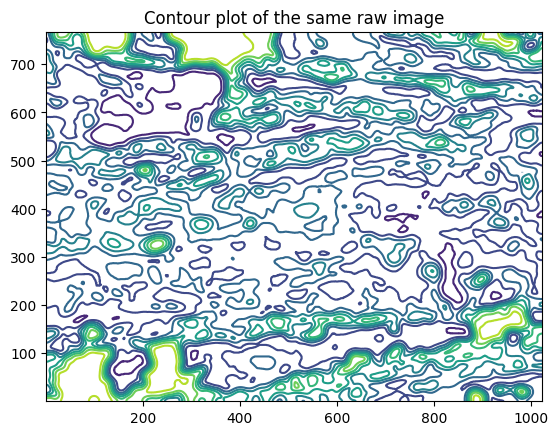

In [4]:
# Show contour of cells 
# fig, ax = plt.subplots(figsize=(5, 5))
fig, ax = plt.subplots()
qcs = ax.contour(image, origin='image')
ax.set_title('Contour plot of the same raw image')
plt.show()

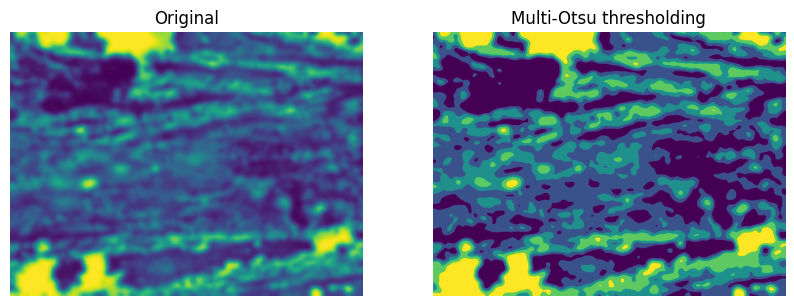

In [5]:
# A thresholds to remove noise 
thresholds = filters.threshold_multiotsu(image, classes=5)
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu thresholding')
ax[1].axis('off')
plt.show()

In [6]:
# Sử dụng np.unique để xác định các giá trị duy nhất
unique_values, counts = np.unique(regions, return_counts=True)

# In ra các giá trị duy nhất và số lần xuất hiện của chúng
print("Các giá trị duy nhất:", unique_values)
print("Số lần xuất hiện tương ứng:", counts)

Các giá trị duy nhất: [0 1 2 3 4]
Số lần xuất hiện tương ứng: [195653 276010 176243  89737  48789]


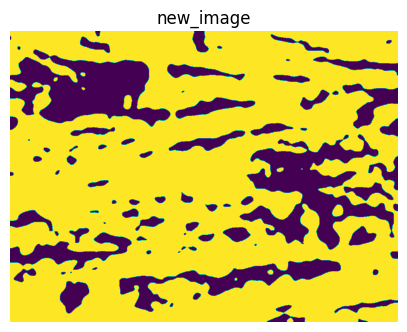

In [7]:
import numpy as np

def replace_value(matrix, old_value, new_value):
    """
    Chuyển đổi mọi phần tử có giá trị là old_value thành new_value trong ma trận.
    
    Parameters:
    - matrix: Ma trận đầu vào
    - old_value: Giá trị cần được thay thế
    - new_value: Giá trị mới
    """
    return np.where(matrix == old_value, new_value, matrix)

new_image = replace_value(regions, 2, 1)
new_image = replace_value(new_image, 3, 1)
new_image = replace_value(new_image, 4, 1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(new_image)
ax.set_title('new_image')
ax.axis('off')
plt.show()

In [8]:
# Sử dụng np.unique để xác định các giá trị duy nhất
unique_values, counts = np.unique(new_image, return_counts=True)

# In ra các giá trị duy nhất và số lần xuất hiện của chúng
print("Các giá trị duy nhất:", unique_values)
print("Số lần xuất hiện tương ứng:", counts)

Các giá trị duy nhất: [0 1]
Số lần xuất hiện tương ứng: [195653 590779]


In [23]:
import cv2
import numpy as np

def cluster_and_crop(image, num_clusters, crop_size):
    # Tìm tâm của các cụm
    data = np.argwhere(image == 0)  # Chỉ xem xét các điểm có giá trị là 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(data.astype(np.float32), num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Làm tròn tâm của các cụm
    centers = np.round(centers).astype(int)

    # Tạo 20 ảnh cắt từ các tâm của các cụm
    cropped_images = []
    for center in centers:
        x, y = center
        half_size = crop_size // 2
        cropped_img = image[x - half_size:x + half_size, y - half_size:y + half_size]
        cropped_images.append(cropped_img)
    
    return cropped_images

# Load ảnh và chuyển đổi thành ảnh nhị phân (chứa các giá trị 0 hoặc 1)
binary_image = new_image
# _, binary_image = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY)

# Số cụm và kích thước cắt
num_clusters = 20
crop_size = 224

# Phân cụm và cắt ảnh
cropped_images = cluster_and_crop(binary_image, num_clusters, crop_size)

# Lưu các ảnh đã cắt
# for i, img in enumerate(cropped_images):
#     cv2.imwrite(f"cropped_image_{i}.jpg", img)


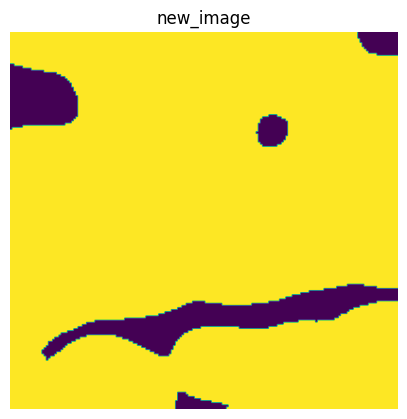

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cropped_images[6])
ax.set_title('new_image')
ax.axis('off')
plt.show()

In [25]:
for i in range(20):
    print(cropped_images[i].shape) # know how to remove picture have size != (212, 212)

(224, 0)
(224, 224)
(224, 201)
(224, 224)
(224, 0)
(203, 224)
(178, 183)
(224, 224)
(212, 224)
(224, 224)
(224, 224)
(0, 224)
(224, 224)
(224, 224)
(0, 224)
(224, 175)
(222, 224)
(224, 224)
(0, 224)
(224, 224)


/tmp/ipykernel_6908/3442389101.py:5: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i][j].imshow(cropped_images[index], cmap='gray')
/tmp/ipykernel_6908/3442389101.py:5: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[i][j].imshow(cropped_images[index], cmap='gray')


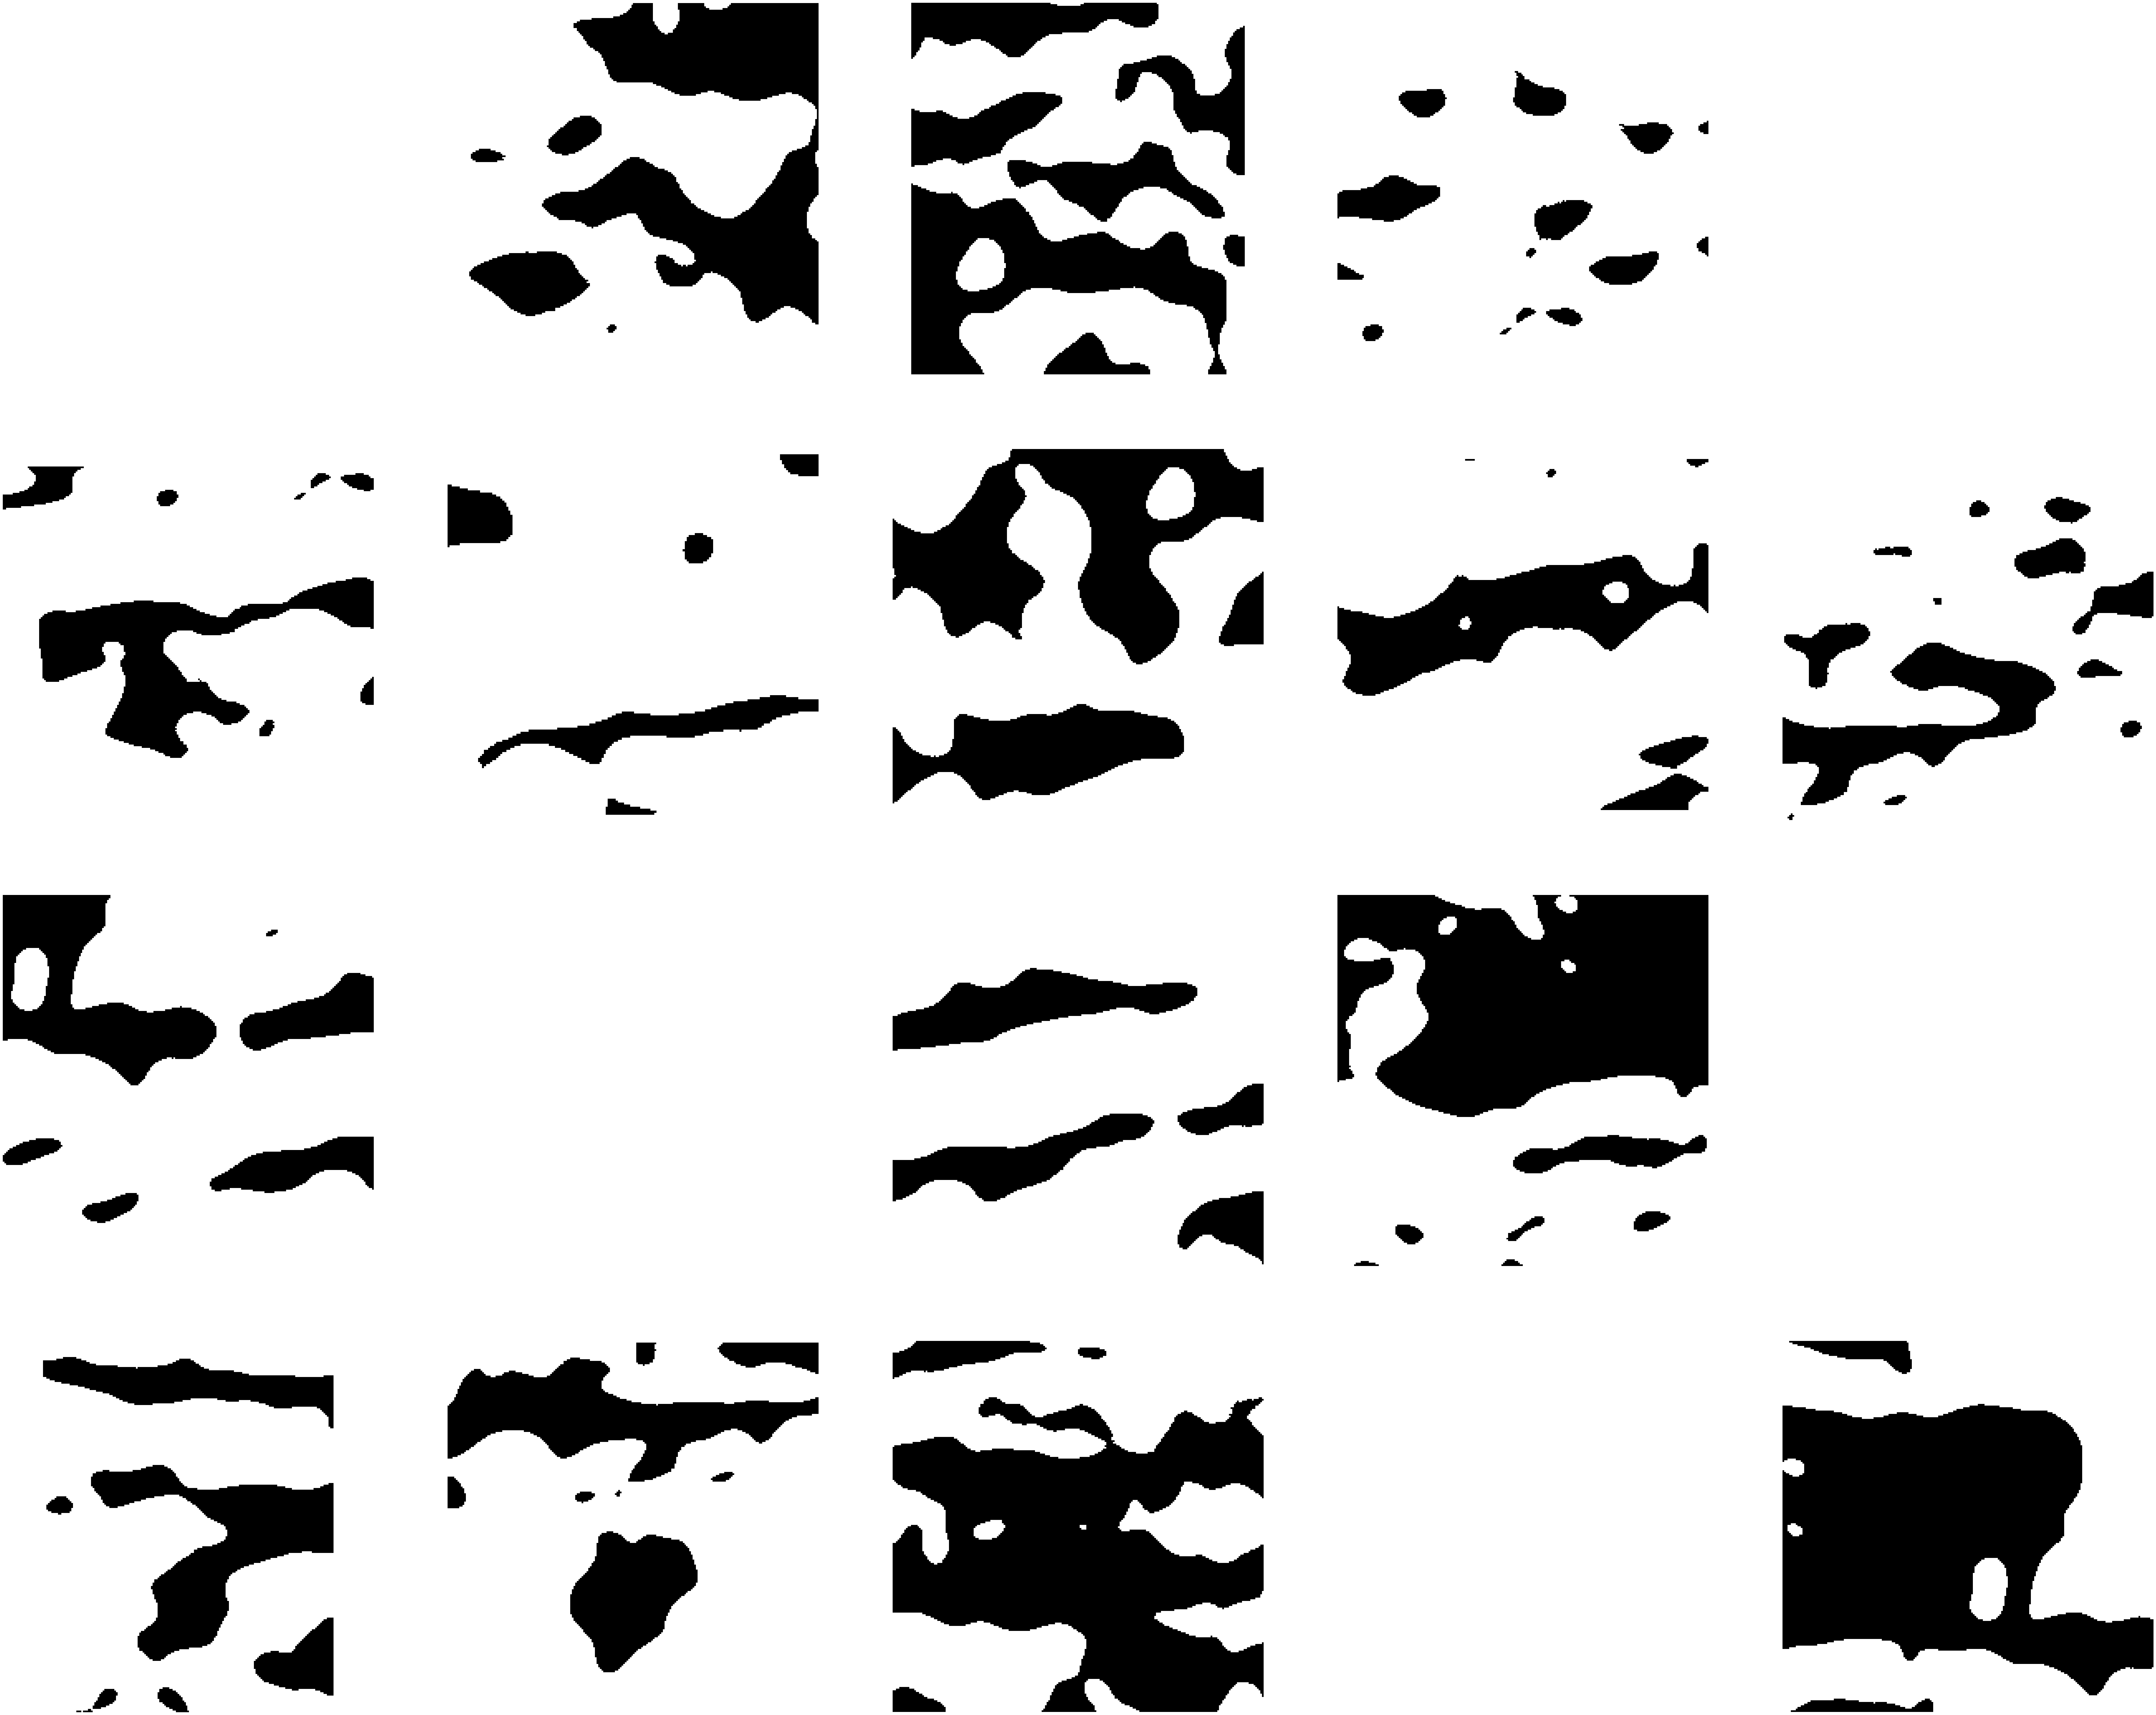

In [26]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(100, 80))
index = 0
for i in range(4):
    for j in range(5):
        ax[i][j].imshow(cropped_images[index], cmap='gray')
        ax[i][j].axis('off')
        index += 1
plt.show()

In [ ]:
import numpy as np

def process_images(cropped_images):
    processed_images = []
    for img in cropped_images:
        if img.shape[0] == 0 or img.shape[1] == 0:
            continue  # Loại bỏ ảnh có một thành phần chiều là 0
        elif img.shape[0] != 212 or img.shape[1] != 212:
            # Nếu kích thước không phù hợp, ghép thêm phần nền trắng để đảm bảo kích thước (212, 212)
            new_img = np.ones((212, 212), dtype=np.uint8)
            new_img[:img.shape[0], :img.shape[1]] = img
            processed_images.append(new_img)
        else:
            processed_images.append(img)
    return processed_images


processed_images = process_images(cropped_images)

In [ ]:
print(len(processed_images))

In [ ]:
for i in range(15):
    print(processed_images[i].shape)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(100, 80))
index = 0
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(processed_images[index], cmap='gray')
        ax[i][j].axis('off')
        index += 1
plt.show()